# Momentum Diffusion

This notebooks gives an overview about the *MomentumDiffusion* module and shortly explains the theoretical background. Momentum diffusion or Second Order Fermi Acceleration is a process in which the particle ensemble gains energy on average due to scattering in magnetic turbulence. In contrast to diffusive shock acceleration (DSA - First Order Fermi Acceleration) individual particles can however loose significant amounts of energy.


The stationary transport equation ($\partial_t f = 0$) for pure momenetum diffusion - neglecting all other terms - can be written as:

$0 = \frac{\partial}{\partial p}\left[p^2 D_{pp} \frac{\partial}{\partial p}\left(\frac{n}{p^2}\right) \right]$, 

where $n$ is the particle density, $p$ is the absolute momentum and $D_{pp}$ is the momentum diffusion scalar. For a constant momentum diffusion coefficient $D_{pp}=\mathrm{const.}$, the stationary solution can be solved analytically and we get a simple momentum dependence for the particle density: $n \propto p^1$. So, momentum diffusion (with a constant diffusion coefficient) can lead to much harder spectra than DSA. However, the acceleration time scales are usually much larger than for DSA.

Further information can be found, e.g., in [Stawarz and Petrosian, ApJ **681** (2008) 1725-1744](https://iopscience.iop.org/article/10.1086/588813).


In [1]:
%matplotlib widget

import crpropa as crp
from crpropa import c_light, meter, second
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## Functionality to run the simulation and analyse the data

In [2]:
def loadData(filename: str) -> pd.DataFrame:
    """Loading CRPropa data file into a pandas DataFrame
    The columns are derived from reading the header.
    Args:
        filename (str): CRPropa textout to be loaded
    Returns:
        pd.DataFrame: CRPropa simulation results
    """

    with open(filename, 'r') as f:
        names = (f.readline()[:-1]).split('\t')[1:]
    df = pd.read_csv(filename, delimiter='\t', comment='#', names=names, low_memory=False)
    return df

def TimeIntegrateSpectrum(df : pd.DataFrame, time : float, bins : np.array, weighted : bool=False) -> tuple:
    """Time integrated spectrum

    Sums all snapshots until simulation time 'time' to calculate the energy spectrum J including 
    its standard deviation dJ, central energy of the histogram binCenters, and the mean energy of
    the full particle ensemble meanE.

    Args:
        df (pd.DataFrame): Simulation data, e.g., loaded with 'loadData'.
        time (float): maximal integration time
        bins (np.array): binning used for the energy spectrum
        weighted (bool, optional): Flag to include weights, e.g., from particle splitting. Defaults to False.

    Returns:
        tuple(J, dJ, binCenter, meanE)
    """

    E = df.loc[df["T"] <= time, "E"]
    meanE = E.mean()

    if weighted:
        HW = np.histogram(E, bins = bins, weights = df.loc[df["T"] <= time, "W"])
    H = np.histogram(E, bins = bins)

    bin_edges = H[1]
    bin_width = bin_edges[1:] - bin_edges[:-1]
    bin_center = bin_edges[:-1] + 0.5 * bin_width

    if weighted:
        J = HW[0]/bin_width
        dJ = J/np.sqrt(H[0])
    else:
        J = H[0]/bin_width
        dJ = np.sqrt(H[0])/bin_width

    return J, dJ, bin_center, meanE


def linFit(x: np.array, a: float, b: float) -> np.array:
    """Linear Function
    f(x) -> a*x + b

    Args:
        x (np.array): input values
        a (float): gradient
        b (float): offset

    Returns:
        np.array: solution
    """

    return a*x+b


def logFit(x: np.array, alpha: float, x_0: float=1.) -> np.array:
    """Linear Function
    f(x) -> a*x + b

    Args:
        x (np.array): input values
        alpha (float): spectral index
        x_0 (float=1.): normalization

    Returns:
        np.array: solution
    """

    return x_0*x**alpha

def Run_MomentumDiffusion(dpp : float=1, dxx : float=1, alpha : float=0., 
                          p_0 : float=1., mono : bool=True, N_obs : int=10000, N_cand : int=1000, 
                          B0 : crp.Vector3d=crp.Vector3d(1,0,0), epsilon : float=0., step : float=1e-3*c_light, 
                          src_pos : crp.Vector3d=crp.Vector3d(0.), src_ID : crp.nucleusId=crp.nucleusId(1, 1)) -> None:
    """Simulation of momentum diffusion

    Args:
        dpp (float, optional): Momentum diffusion scalar. Defaults to 1.
        dxx (float, optional): Spatial diffusion scalar. Defaults to 1.
        alpha (float, optional): Power law index of spatial diffusion energy dependence. Defaults to 0..
        p_0 (float, optional): Injection Momentum. Defaults to 1..
        mono (bool, optional): Flag for mono-energetic source spectrum. Defaults to True.
        N_obs (int, optional): Number of observation points in time. Defaults to 10000.
        N_cand (int, optional): Number of injected candidates. Defaults to 1000.
        B0 (crp.Vector3d, optional): Background magnetic field direction - sets diffusion direction, too. Defaults to crp.Vector3d(1,0,0).
        epsilon (float, optional): Ratio between perpendicular and parallel diffusion scalars. Defaults to 0..
        step (float, optional): Integration step size. Defaults to 1e-3*c_light.
        src_pos (crp.Vector3d, optional): Source position. Defaults to crp.Vector3d(0.).
        src_ID (crp.nucleusId, optional): Particle type. Defaults to crp.nucleusId(1, 1).
    """
    

    scale = dxx / (6.1*1e24 * meter**2. / second)
    E_0 = p_0 * c_light
    E_min = E_0/10
    D_min = 100 * step
    deltaD = 100 * step
    maxD = (N_obs) * deltaD


    Bfield = crp.UniformMagneticField(B0)

    spatialDiff = crp.DiffusionSDE(Bfield, 1e-4, step, step)
    spatialDiff.setEpsilon(epsilon)
    spatialDiff.setScale(scale)
    spatialDiff.setAlpha(alpha)

    momentumDiff = crp.ConstantMomentumDiffusion(dpp)

    out = crp.TextOutput('MomentumDiffusion_p0-{}_dpp-{}_dxx-{}_delT-{}_Nobs-{}_delTobs-{}_mono-{}.txt'.format(p_0, dpp, dxx, step/c_light, N_obs, deltaD/c_light, mono))
    out.disableAll()
    out.enable(crp.Output.CurrentPositionColumn)
    out.enable(crp.Output.CurrentEnergyColumn)
    out.enable(crp.Output.TrajectoryLengthColumn)
    out.setLengthScale(meter) 
    out.setEnergyScale(E_0)

    obs = crp.Observer()
    obs.add(crp.ObserverTimeEvolution(D_min, deltaD, N_obs))
    obs.onDetection(out)
    obs.setDeactivateOnDetection(False)

    maxTra = crp.MaximumTrajectoryLength(maxD)
    minEnergy = crp.MinimumEnergy(0.) #Seems to be needed, otherwise infs can appear

    src = crp.Source()
    src.add(crp.SourceIsotropicEmission())
    src.add(crp.SourceParticleType(src_ID))

    if mono:
        src.add(crp.SourceEnergy(E_0))
    else:
        src.add(crp.SourcePowerLawSpectrum(E_min, E_0, -1))
    src.add(crp.SourcePosition(src_pos))

    sim = crp.ModuleList()

    sim.add(spatialDiff)
    sim.add(momentumDiff)
    sim.add(obs)
    sim.add(maxTra)
    sim.add(minEnergy)

    sim.setShowProgress(True)
    sim.run(src, N_cand)

    out.close()

### Slow time evolution setup 

Here, a momentum diffusion coefficient of $D_{pp}=1$ is used.

In [3]:
# settings

dpp_1 = 1
dxx_1 = 1
alpha_1 = 0.
p_0_1 = 1
mono_1 = True #switch for monoenergetic or power law injection.

N_obs_1 = 10000
N_cand_1 = 1000

step_1 = 1e-3 * c_light
deltaD_1 = 100 * step_1

In [4]:
# Run the simulation
Run_MomentumDiffusion(dpp =dpp_1, dxx=dxx_1, alpha=alpha_1, p_0=p_0_1, mono=mono_1, N_obs=N_obs_1, N_cand=N_cand_1, step=step_1)

crpropa::ModuleList: Number of Threads: 8
Run ModuleList


  Started Mon Oct 16 15:28:27 2023 : [ Finished ] 100%    Needed: 00:02:59  - Finished at Mon Oct 16 15:31:26 2023


In [5]:
# Load data
df_1 = loadData('MomentumDiffusion_p0-{}_dpp-{}_dxx-{}_delT-{}_Nobs-{}_delTobs-{}_mono-{}.txt'.format(p_0_1, dpp_1, dxx_1, step_1/c_light, N_obs_1, deltaD_1/c_light, mono_1))
df_1["T"] = df_1["D"]/c_light
del (df_1["D"])
del (df_1["Y"])
del (df_1["Z"])

times_1 = df_1["T"].unique()

groups_1 = df_1.groupby(df_1["T"])

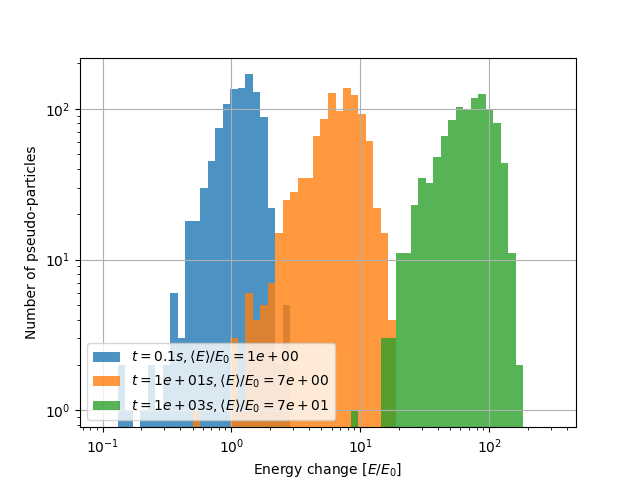

In [6]:
# Visualisation

plt.figure()
bins = np.logspace(-1, 2.5 , 61)

for t in [times_1[0], times_1[99], times_1[9999]]:
    energies = groups_1.get_group(t).E
    energies.hist(bins=bins, label=r"$t={:.1}s, \langle E\rangle/E_0={:.1}$".format(t, energies.mean()), alpha=0.8)
plt.loglog()
plt.xlabel('Energy change [$E/E_0$]')
plt.ylabel('Number of pseudo-particles')
plt.legend(loc='lower left')
plt.show()

**Figure 1:** Time evolution of the energy spectrum for a burst-like injection $S(p, t) = \delta(p-p_0)\delta(t)$. It is visible that the particle ensemble gains energy on average but the distribution in momentum space gets wider, too.

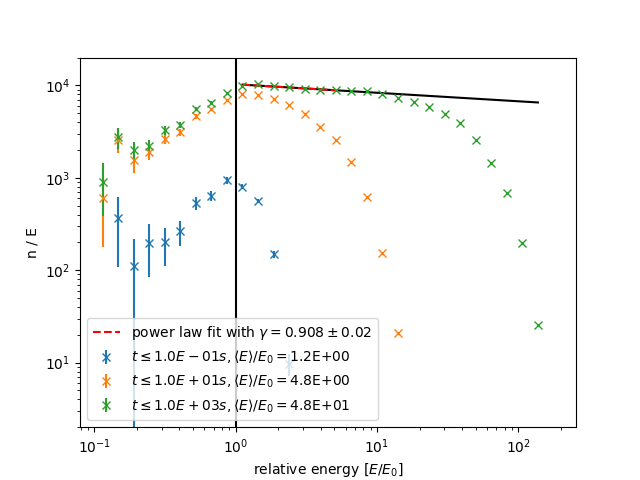

No such comm: 9c35f3cce6a946699c7cb0f365cf00a3


In [7]:
plt.close()
plt.figure()
binEdges = np.logspace(-1., 2.3, 31)

fit_range = slice(9, -14)
plot_range = slice(9,-1)

#for t in [times[0], times[9], times[99], times[999], times[9999]]:
for t in [times_1[0], times_1[99], times_1[9999]]:

    J, dJ, bin_center, meanE = TimeIntegrateSpectrum(df_1, t, binEdges, weighted = False) #restrict to get spectrum close to the shock
    plt.errorbar(bin_center, J/bin_center, yerr=dJ/bin_center, marker='x', linestyle='', label=r"$t\leq{:.1E}s, \langle E\rangle/E_0=${:.1E} ".format(t, meanE))

    if t == times_1[9999]:
        popt, cov = curve_fit(linFit, np.log10(bin_center)[fit_range], np.log10(J)[fit_range])

        x_plot = bin_center[plot_range]
        f_plot = logFit(x_plot, popt[0], 10**popt[1])
        plt.plot(x_plot, f_plot/x_plot, color='k', linestyle='-')

        x_fit = bin_center[fit_range]
        f_fit = logFit(x_fit, popt[0], 10**popt[1])
        plt.plot(x_fit, f_fit/x_fit, color='r', linestyle='--', label=r'power law fit with $\gamma={:.3}\pm{:.1}$'.format(popt[0], np.sqrt(cov[0, 0])))


    


plt.plot((1, 1), (1e-4, 2e4), 'k')
plt.ylim(2e-0, 2e4)
plt.loglog()
plt.xlabel('relative energy [$E/E_0$]')
plt.ylabel('n / E')
plt.legend()
plt.show()

**Figure 2:** Different approximations of the stationary solution ($\partial_t n=0$). The more snap shots of the time evolution are taken into accound (here by increasing the time) the better the analytically expected result $n\propto E$ is matched. The solid line shows a power law fit to the data. As we do expect a cut-off in the energy spectrum due to the finite simulation time not all data are taken into account. The fitted energy range is denoted by the red dashed line. With sufficient resolution of the time snaps, the solution corresponds to the spectra at time $t$ with continuous injection of particles.  

### Fast time evolution setup 

Here, a momentum diffusion coefficient of $D_{pp}=10$ is used.

In [8]:
# settings

dpp_10 = 10
dxx_10 = 1
alpha_10 = 0.
p_0_10 = 1
mono_10 = True #switch for monoenergetic or power law injection.

N_obs_10 = 10000
N_cand_10 = 1000

step_10 = 1e-3 * c_light
deltaD_10 = 100 * step_10

In [9]:
# Run the simulation
Run_MomentumDiffusion(dpp =dpp_10, dxx=dxx_10, alpha=alpha_10, p_0=p_0_10, mono=mono_10, N_obs=N_obs_10, N_cand=N_cand_10)

crpropa::ModuleList: Number of Threads: 8
Run ModuleList
  Started Mon Oct 16 15:31:33 2023 : [ Finished ] 100%    Needed: 00:02:57  - Finished at Mon Oct 16 15:34:30 2023


In [10]:
# Load data
df_10 = loadData('MomentumDiffusion_p0-{}_dpp-{}_dxx-{}_delT-{}_Nobs-{}_delTobs-{}_mono-{}.txt'.format(p_0_10, dpp_10, dxx_10, step_10/c_light, N_obs_10, deltaD_10/c_light, mono_10))
df_10["T"] = df_10["D"]/c_light
del (df_10["D"])
del (df_10["Y"])
del (df_10["Z"])

times_10 = df_10["T"].unique()

groups_10 = df_10.groupby(df_10["T"])

/tmp/ipykernel_3178606/2660489551.py:16: RuntimeWarning: divide by zero encountered in log10
  popt, cov = curve_fit(linFit, np.log10(bin_center)[fit_range], np.log10(J)[fit_range])


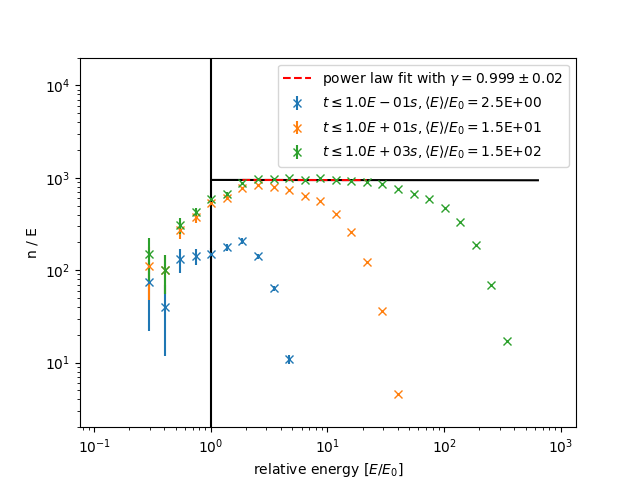

In [11]:
# Visualisation

plt.close()
plt.figure()
binEdges = np.logspace(-1., 3., 31)

fit_range = slice(9, -12)
plot_range = slice(7,-1)

for t in [times_10[0], times_10[99], times_10[9999]]:

    J, dJ, bin_center, meanE = TimeIntegrateSpectrum(df_10, t, binEdges, weighted = False) #restrict to get spectrum close to the shock
    plt.errorbar(bin_center, J/bin_center, yerr=dJ/bin_center, marker='x', linestyle='', label=r"$t\leq{:.1E}s, \langle E\rangle/E_0=${:.1E} ".format(t, meanE))

    if t == times_1[9999]:
        popt, cov = curve_fit(linFit, np.log10(bin_center)[fit_range], np.log10(J)[fit_range])

        x_plot = bin_center[plot_range]
        f_plot = logFit(x_plot, popt[0], 10**popt[1])
        plt.plot(x_plot, f_plot/x_plot, color='k', linestyle='-')

        x_fit = bin_center[fit_range]
        f_fit = logFit(x_fit, popt[0], 10**popt[1])
        plt.plot(x_fit, f_fit/x_fit, color='r', linestyle='--', label=r'power law fit with $\gamma={:.3}\pm{:.1}$'.format(popt[0], np.sqrt(cov[0, 0])))


    


plt.plot((1, 1), (1e-4, 2e4), 'k')
plt.ylim(2e-0, 2e4)
plt.loglog()
plt.xlabel('relative energy [$E/E_0$]')
plt.ylabel('n / E')
plt.legend()
plt.show()

**Figure 3:** Same as in figure 2 but for a larger momentum diffusion scalar. It is visible that the time evolution is faster and higher energies are reached in the same time. However, the approximation close to $E_0$ is worse than for the case with $D_{pp}=1$. This could be improved by taking more snapshot at ealier times into account/increasing the resolution in time. 